# Flatiron Data Science Project 3: SMS Spam Detection Model

First, import the necessary packages

In [42]:
import pandas as pd
import string
import nltk
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Next, we read our dataset to a pandas DataFrame

In [43]:
category_list = []
message_list = []

with open('./data/SMSSpamCollection') as f:
    for line in f:
        row = line.split('\t', maxsplit=1)
        category_list.append(row[0])
        message_list.append(row[1])

dict = {'Category': category_list, 'Message': message_list}
df = pd.DataFrame(data=dict)
df['Category'] = df['Category'].replace(['ham', 'spam'], [0, 1])
df

/var/folders/4s/pf1zdv_x4_qcflpq4m943q0m0000gn/T/ipykernel_77414/4088057831.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Category'] = df['Category'].replace(['ham', 'spam'], [0, 1])


,Category,Message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...\n
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5569,1,This is the 2nd time we have tried 2 contact u...
5570,0,Will ü b going to esplanade fr home?\n
5571,0,"Pity, * was in mood for that. So...any other s..."
5572,0,The guy did some bitching but I acted like i'd...


Let's look at the distribution of spam and ham (non-spam) messages:

In [44]:
df['Category'].value_counts()

Category
0    4827
1     747
Name: count, dtype: int64

In [45]:
df['Category'].value_counts(normalize=True)

Category
0    0.865985
1    0.134015
Name: proportion, dtype: float64

Our dataset has a large amount of class imbalance. We'll address this partially by adding some supplimentary spam messages to the set. We'll take another look at this when we refine our logistic regression model.

In [46]:
new_spam_df = pd.read_csv('./data/spam-text-messages.txt')
new_spam_df = new_spam_df.drop(columns=['message_id']).rename(columns={"message_text": "Message", "spam_label" : "Category"})
df = pd.concat([new_spam_df, df])
df['Category'].value_counts()

Category
0    4827
1     947
Name: count, dtype: int64

## Text Preprossessing

Here, we'll process our dataset so that we can easily feed it into our models

In [47]:
df_cleaning = df.copy()

First, we convert all of the text to lowercase

In [48]:
df_cleaning['lower_message'] = df_cleaning['Message'].str.lower()
df_cleaning

,Message,Category,lower_message
0,"URGENT: Your mobile number has won $500,000 in...",1,"urgent: your mobile number has won $500,000 in..."
1,CONGRATULATIONS! You've been selected for a fr...,1,congratulations! you've been selected for a fr...
2,Your package delivery #8742 is pending. Update...,1,your package delivery #8742 is pending. update...
3,NETFLIX: Your account has been suspended. Upda...,1,netflix: your account has been suspended. upda...
4,50% OFF at Fashion World! Limited time offer. ...,1,50% off at fashion world! limited time offer. ...
...,...,...,...
5569,This is the 2nd time we have tried 2 contact u...,1,this is the 2nd time we have tried 2 contact u...
5570,Will ü b going to esplanade fr home?\n,0,will ü b going to esplanade fr home?\n
5571,"Pity, * was in mood for that. So...any other s...",0,"pity, * was in mood for that. so...any other s..."
5572,The guy did some bitching but I acted like i'd...,0,the guy did some bitching but i acted like i'd...


Then, remove all punctuation

In [ ]:
PUNCT_TO_REMOVE = string.punctuation
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

df_cleaning['message_wo_punct'] = df_cleaning["lower_message"].apply(lambda text: remove_punctuation(text))
df_cleaning

,Message,Category,lower_message,message_wo_punct
0,"URGENT: Your mobile number has won $500,000 in...",1,"urgent: your mobile number has won $500,000 in...",urgent your mobile number has won 500000 in ou...
1,CONGRATULATIONS! You've been selected for a fr...,1,congratulations! you've been selected for a fr...,congratulations youve been selected for a free...
2,Your package delivery #8742 is pending. Update...,1,your package delivery #8742 is pending. update...,your package delivery 8742 is pending update d...
3,NETFLIX: Your account has been suspended. Upda...,1,netflix: your account has been suspended. upda...,netflix your account has been suspended update...
4,50% OFF at Fashion World! Limited time offer. ...,1,50% off at fashion world! limited time offer. ...,50 off at fashion world limited time offer sho...
...,...,...,...,...
5569,This is the 2nd time we have tried 2 contact u...,1,this is the 2nd time we have tried 2 contact u...,this is the 2nd time we have tried 2 contact u...
5570,Will ü b going to esplanade fr home?\n,0,will ü b going to esplanade fr home?\n,will ü b going to esplanade fr home\n
5571,"Pity, * was in mood for that. So...any other s...",0,"pity, * was in mood for that. so...any other s...",pity was in mood for that soany other suggest...
5572,The guy did some bitching but I acted like i'd...,0,the guy did some bitching but i acted like i'd...,the guy did some bitching but i acted like id ...


Next, we'll remove very common English words from each string so that the model isn't biased towards them. We'll use a package called nltk (Natural Language Toolkit) to accomplish this.

In [50]:
from nltk.corpus import stopwords

STOPWORDS = set(stopwords.words('english'))
def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

df_cleaning['message_no_stopwords'] = df_cleaning['message_wo_punct'].apply(lambda text: remove_stopwords(text))
df_cleaning

,Message,Category,lower_message,message_wo_punct,message_no_stopwords
0,"URGENT: Your mobile number has won $500,000 in...",1,"urgent: your mobile number has won $500,000 in...",urgent your mobile number has won 500000 in ou...,urgent mobile number 500000 prize draw call cl...
1,CONGRATULATIONS! You've been selected for a fr...,1,congratulations! you've been selected for a fr...,congratulations youve been selected for a free...,congratulations youve selected free iphone 14 ...
2,Your package delivery #8742 is pending. Update...,1,your package delivery #8742 is pending. update...,your package delivery 8742 is pending update d...,package delivery 8742 pending update delivery ...
3,NETFLIX: Your account has been suspended. Upda...,1,netflix: your account has been suspended. upda...,netflix your account has been suspended update...,netflix account suspended update payment info ...
4,50% OFF at Fashion World! Limited time offer. ...,1,50% off at fashion world! limited time offer. ...,50 off at fashion world limited time offer sho...,50 fashion world limited time offer shop fwsal...
...,...,...,...,...,...
5569,This is the 2nd time we have tried 2 contact u...,1,this is the 2nd time we have tried 2 contact u...,this is the 2nd time we have tried 2 contact u...,2nd time tried 2 contact u u £750 pound prize ...
5570,Will ü b going to esplanade fr home?\n,0,will ü b going to esplanade fr home?\n,will ü b going to esplanade fr home\n,ü b going esplanade fr home
5571,"Pity, * was in mood for that. So...any other s...",0,"pity, * was in mood for that. so...any other s...",pity was in mood for that soany other suggest...,pity mood soany suggestions
5572,The guy did some bitching but I acted like i'd...,0,the guy did some bitching but i acted like i'd...,the guy did some bitching but i acted like id ...,guy bitching acted like id interested buying s...


Finally, we'll *lemmatize* each string, or reduce it to it's root form (eg: running -> run)

In [51]:
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}
def lemmatize_words(text):
    pos_tagged_text = nltk.pos_tag(text.split(), lang='eng')
    return " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text])

df_cleaning['message_lemmatized'] = df_cleaning['message_no_stopwords'].apply(lambda text: lemmatize_words(text))
df_cleaning

,Message,Category,lower_message,message_wo_punct,message_no_stopwords,message_lemmatized
0,"URGENT: Your mobile number has won $500,000 in...",1,"urgent: your mobile number has won $500,000 in...",urgent your mobile number has won 500000 in ou...,urgent mobile number 500000 prize draw call cl...,urgent mobile number 500000 prize draw call cl...
1,CONGRATULATIONS! You've been selected for a fr...,1,congratulations! you've been selected for a fr...,congratulations youve been selected for a free...,congratulations youve selected free iphone 14 ...,congratulation youve select free iphone 14 cli...
2,Your package delivery #8742 is pending. Update...,1,your package delivery #8742 is pending. update...,your package delivery 8742 is pending update d...,package delivery 8742 pending update delivery ...,package delivery 8742 pending update delivery ...
3,NETFLIX: Your account has been suspended. Upda...,1,netflix: your account has been suspended. upda...,netflix your account has been suspended update...,netflix account suspended update payment info ...,netflix account suspend update payment info ne...
4,50% OFF at Fashion World! Limited time offer. ...,1,50% off at fashion world! limited time offer. ...,50 off at fashion world limited time offer sho...,50 fashion world limited time offer shop fwsal...,50 fashion world limit time offer shop fwsales...
...,...,...,...,...,...,...
5569,This is the 2nd time we have tried 2 contact u...,1,this is the 2nd time we have tried 2 contact u...,this is the 2nd time we have tried 2 contact u...,2nd time tried 2 contact u u £750 pound prize ...,2nd time try 2 contact u u £750 pound prize 2 ...
5570,Will ü b going to esplanade fr home?\n,0,will ü b going to esplanade fr home?\n,will ü b going to esplanade fr home\n,ü b going esplanade fr home,ü b go esplanade fr home
5571,"Pity, * was in mood for that. So...any other s...",0,"pity, * was in mood for that. so...any other s...",pity was in mood for that soany other suggest...,pity mood soany suggestions,pity mood soany suggestion
5572,The guy did some bitching but I acted like i'd...,0,the guy did some bitching but i acted like i'd...,the guy did some bitching but i acted like id ...,guy bitching acted like id interested buying s...,guy bitch act like id interested buying someth...


In [52]:
df_cleaning['Category'] = df_cleaning['Category'].replace(['ham', 'spam'], [0, 1])
df_cleaning

,Message,Category,lower_message,message_wo_punct,message_no_stopwords,message_lemmatized
0,"URGENT: Your mobile number has won $500,000 in...",1,"urgent: your mobile number has won $500,000 in...",urgent your mobile number has won 500000 in ou...,urgent mobile number 500000 prize draw call cl...,urgent mobile number 500000 prize draw call cl...
1,CONGRATULATIONS! You've been selected for a fr...,1,congratulations! you've been selected for a fr...,congratulations youve been selected for a free...,congratulations youve selected free iphone 14 ...,congratulation youve select free iphone 14 cli...
2,Your package delivery #8742 is pending. Update...,1,your package delivery #8742 is pending. update...,your package delivery 8742 is pending update d...,package delivery 8742 pending update delivery ...,package delivery 8742 pending update delivery ...
3,NETFLIX: Your account has been suspended. Upda...,1,netflix: your account has been suspended. upda...,netflix your account has been suspended update...,netflix account suspended update payment info ...,netflix account suspend update payment info ne...
4,50% OFF at Fashion World! Limited time offer. ...,1,50% off at fashion world! limited time offer. ...,50 off at fashion world limited time offer sho...,50 fashion world limited time offer shop fwsal...,50 fashion world limit time offer shop fwsales...
...,...,...,...,...,...,...
5569,This is the 2nd time we have tried 2 contact u...,1,this is the 2nd time we have tried 2 contact u...,this is the 2nd time we have tried 2 contact u...,2nd time tried 2 contact u u £750 pound prize ...,2nd time try 2 contact u u £750 pound prize 2 ...
5570,Will ü b going to esplanade fr home?\n,0,will ü b going to esplanade fr home?\n,will ü b going to esplanade fr home\n,ü b going esplanade fr home,ü b go esplanade fr home
5571,"Pity, * was in mood for that. So...any other s...",0,"pity, * was in mood for that. so...any other s...",pity was in mood for that soany other suggest...,pity mood soany suggestions,pity mood soany suggestion
5572,The guy did some bitching but I acted like i'd...,0,the guy did some bitching but i acted like i'd...,the guy did some bitching but i acted like id ...,guy bitching acted like id interested buying s...,guy bitch act like id interested buying someth...


Next, we'll make wordclouds to visualize the distribution of words in each category (spam vs. non spam)

In [53]:
spam = df_cleaning[df_cleaning['Category'] == 1]
ham = df_cleaning[df_cleaning['Category'] == 0]

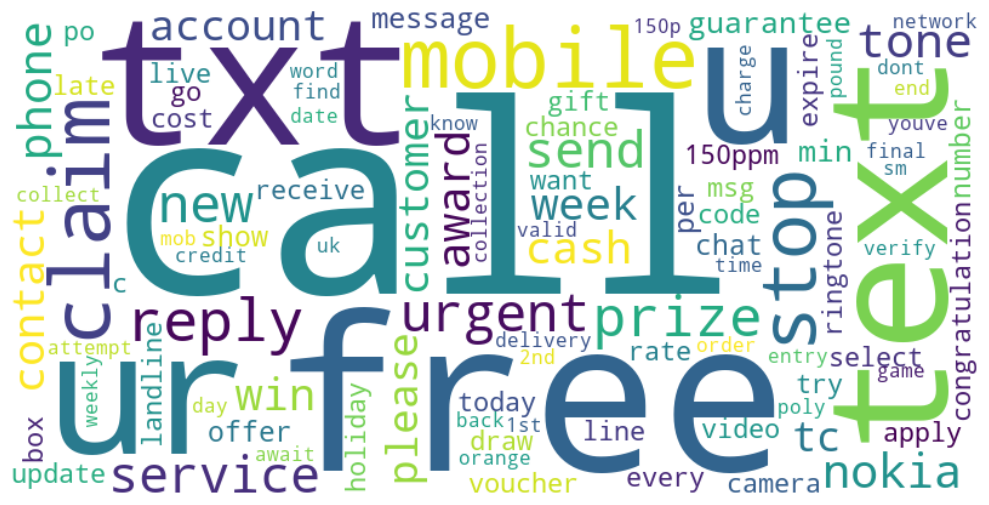

In [54]:
from wordcloud import WordCloud
spam_text_combined = ' '.join(spam['message_lemmatized'].dropna())

wordcloud = WordCloud(
    width=800, 
    height=400,
    background_color='white',
    max_words=100,  
    collocations=False,  
    
).generate(spam_text_combined)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout()
plt.show()

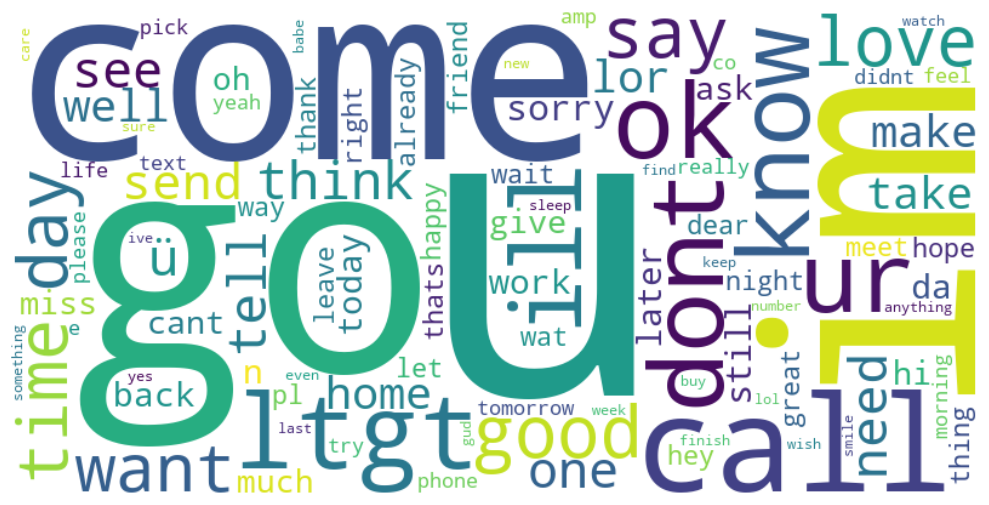

In [55]:
ham_text_combined = ' '.join(ham['message_lemmatized'].dropna())

wordcloud = WordCloud(
    width=800, 
    height=400,
    background_color='white',
    max_words=100,  
    collocations=False,  
    
).generate(ham_text_combined)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout()
plt.show()

## Baseline Model

Without doing any further adjustments to the dataset, let's create a Logistic Regression model to set a baseline for performance. In order to use the strings in our dataset correctly, we have to first transform them using a TF-IDF Vectorizer. This transformer assigns each word in the set a score base on two factors: Number of occurances in a given string, and number of occurances in the entire dataset.

In [56]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score, recall_score, precision_score, f1_score
X_train, X_test, y_train, y_test = train_test_split(df_cleaning['message_lemmatized'], df_cleaning['Category'], test_size=.2, random_state=42)

tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print("Shape (number of strings, number of unique words):")
print(X_train_tfidf.shape)
print('List of unique words:')
print(tfidf_vectorizer.get_feature_names_out())
print("Vector Matrix for training data:")
print(X_train_tfidf.toarray())

Shape (number of strings, number of unique words):
(4619, 7751)
List of unique words:
['008704050406' '0089my' '0121' ... 'zoe' 'zogtorius' 'üll']
Vector Matrix for training data:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


Using the newly vectorized data, we can now create a Logistic Regression model and attempt prediction...

In [105]:
from sklearn.linear_model import LogisticRegression

lr_classifier = LogisticRegression(random_state=42)
lr_classifier.fit(X_train_tfidf, y_train)

y_pred_lr = lr_classifier.predict(X_test_tfidf)

class_report_lr = classification_report(y_test, y_pred_lr)
print("Test Data:")
print(f"Accuracy = ", accuracy_score(y_test, y_pred_lr))
print(f"Recall = ", recall_score(y_test, y_pred_lr))
print(f"Precision = ", precision_score(y_test, y_pred_lr))
print(f"F1 Score = ", f1_score(y_test, y_pred_lr))

y_train_pred = lr_classifier.predict(X_train_tfidf)
class_report_train = classification_report(y_train, y_train_pred)
print("Train Data:")
print("Accuracy:", accuracy_score(y_train, y_train_pred))
print(class_report_train)

Test Data:
Accuracy =  0.9567099567099567
Recall =  0.7473118279569892
Precision =  0.9788732394366197
F1 Score =  0.8475609756097561
Train Data:
Accuracy: 0.957350075773977
              precision    recall  f1-score   support

           0       0.95      1.00      0.98      3858
           1       0.99      0.75      0.85       761

    accuracy                           0.96      4619
   macro avg       0.97      0.87      0.91      4619
weighted avg       0.96      0.96      0.95      4619



These are already pretty good results! The accuracy is not perfect for both the test set and the train set, which indicates that the model isn't overfit. Our recall and f1 score are pretty low, but we'll be able to improve these with some hyperparameter tuning. Now, let's make some confusion matrices to see the distribution of positives vs negatives

Test Data:


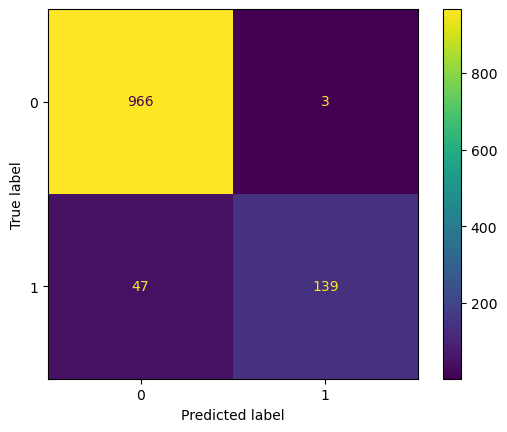

In [59]:
print("Test Data:")
cm = confusion_matrix(y_test, y_pred_lr)
disp = ConfusionMatrixDisplay(cm)
disp.plot()

Train Data:


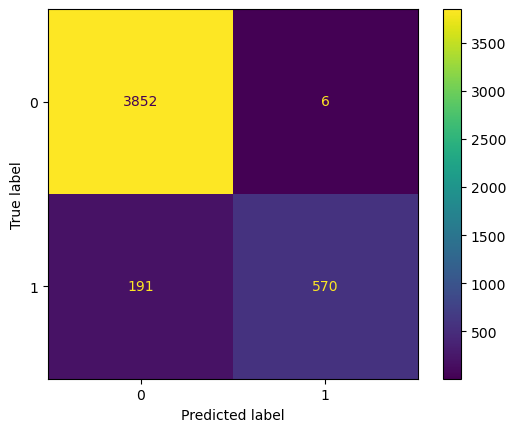

In [60]:
print("Train Data:")
cm = confusion_matrix(y_train, y_train_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()

## Tuned Logistic Regression

In this section, we'll build on our existing logistic regression model by tuning hyperparameters.

First, let's try oversampling with SMOTE and see if that makes a difference

In [62]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

X_train, X_test, y_train, y_test = train_test_split(df_cleaning['message_lemmatized'], df_cleaning['Category'], test_size=.2, random_state=42)

tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print("Shape (number of strings, number of unique words):")
print(X_train_tfidf.shape)
print('List of unique words:')
print(tfidf_vectorizer.get_feature_names_out())
print("Vector Matrix for training data:")
print(X_train_tfidf.toarray())

Shape (number of strings, number of unique words):
(4619, 7751)
List of unique words:
['008704050406' '0089my' '0121' ... 'zoe' 'zogtorius' 'üll']
Vector Matrix for training data:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [106]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42, sampling_strategy=1)
X_oversamp, y_oversamp = sm.fit_resample(X_train_tfidf, y_train)
print(y_oversamp.value_counts())
X_oversamp.shape

Category
0    3858
1    3858
Name: count, dtype: int64


(7716, 7751)

In [107]:
from sklearn.linear_model import LogisticRegression

lr_classifier = LogisticRegression(random_state=42)
lr_classifier.fit(X_oversamp, y_oversamp)

y_pred_lr = lr_classifier.predict(X_test_tfidf)

class_report_lr = classification_report(y_test, y_pred_lr)
print("Test Data:")
print("Accuracy: ", accuracy_score(y_test, y_pred_lr))
print(class_report_lr)

y_train_pred = lr_classifier.predict(X_oversamp)
class_report_train = classification_report(y_oversamp, y_train_pred)
print("Train Data:")
print("Accuracy: ", accuracy_score(y_oversamp, y_train_pred))
print(class_report_train)

Test Data:
Accuracy:  0.9783549783549783
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       969
           1       0.95      0.91      0.93       186

    accuracy                           0.98      1155
   macro avg       0.97      0.95      0.96      1155
weighted avg       0.98      0.98      0.98      1155

Train Data:
Accuracy:  0.9918351477449455
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3858
           1       0.99      0.99      0.99      3858

    accuracy                           0.99      7716
   macro avg       0.99      0.99      0.99      7716
weighted avg       0.99      0.99      0.99      7716



Test Data:


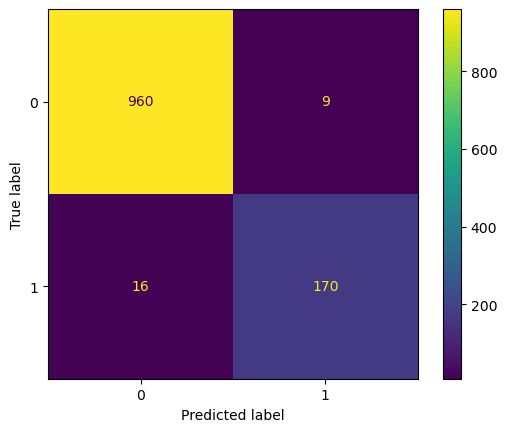

In [108]:
print("Test Data:")
cm = confusion_matrix(y_test, y_pred_lr)
disp = ConfusionMatrixDisplay(cm)
disp.plot()

Train Data:


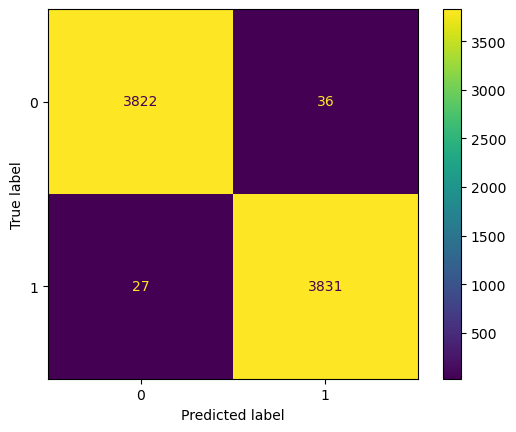

In [109]:
print("Train Data:")
cm = confusion_matrix(y_oversamp, y_train_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()

Using oversampling, we have made our model significantly more accurate

Let's wrap our models in a function so that we will be able to perform hyperparameter tuning easily

In [67]:
def baseline_model(dataframe):
    X_train, X_test, y_train, y_test = train_test_split(dataframe['message_lemmatized'], dataframe['Category'], test_size=.2, random_state=42)

    tfidf_vectorizer = TfidfVectorizer()
    X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
    X_test_tfidf = tfidf_vectorizer.transform(X_test)

    logreg = LogisticRegression(random_state=42)
    logreg.fit(X_train_tfidf, y_train)

    y_pred_lr = lr_classifier.predict(X_test_tfidf)

    return accuracy_score(y_test, y_pred_lr)


In [68]:
def lr_with_oversampling(dataframe, sample_ratio=1, c_value=1, custom_min_df=1):
    X_train, X_test, y_train, y_test = train_test_split(dataframe['message_lemmatized'], dataframe['Category'], test_size=.2, random_state=42)

    tfidf_vectorizer = TfidfVectorizer(min_df=custom_min_df)
    X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
    X_test_tfidf = tfidf_vectorizer.transform(X_test)

    sm = SMOTE(random_state=42, sampling_strategy=sample_ratio)
    X_oversamp, y_oversamp = sm.fit_resample(X_train_tfidf, y_train)

    logreg = LogisticRegression(random_state=42, max_iter=10000, C=c_value)
    logreg.fit(X_oversamp, y_oversamp)

    y_pred_lr = logreg.predict(X_test_tfidf)

    return accuracy_score(y_test, y_pred_lr)

Now that we can call our model easily, let's test different oversampling ratios and look at its impact on the model accuracy

In [69]:
ratio_list = [.3, .4, .5, .6, .7, .8, .9, 1.0]
print("Testing different oversampling ratios:")
default = lr_with_oversampling(df_cleaning)
print(f"Default oversampling method accuracy (1:1): {default}")
acc_list = []
for ratio in ratio_list:
    acc = lr_with_oversampling(df_cleaning, sample_ratio=ratio)
    acc_list.append(acc)
    print(f"Ratio {ratio} Accuracy: {acc}")

Testing different oversampling ratios:
Default oversampling method accuracy (1:1): 0.9783549783549783
Ratio 0.3 Accuracy: 0.9645021645021645
Ratio 0.4 Accuracy: 0.9731601731601731
Ratio 0.5 Accuracy: 0.9748917748917749
Ratio 0.6 Accuracy: 0.974025974025974
Ratio 0.7 Accuracy: 0.9766233766233766
Ratio 0.8 Accuracy: 0.9774891774891775
Ratio 0.9 Accuracy: 0.9766233766233766
Ratio 1.0 Accuracy: 0.9783549783549783


Text(0.5, 1.0, 'Oversampling ratio vs. Accuracy')

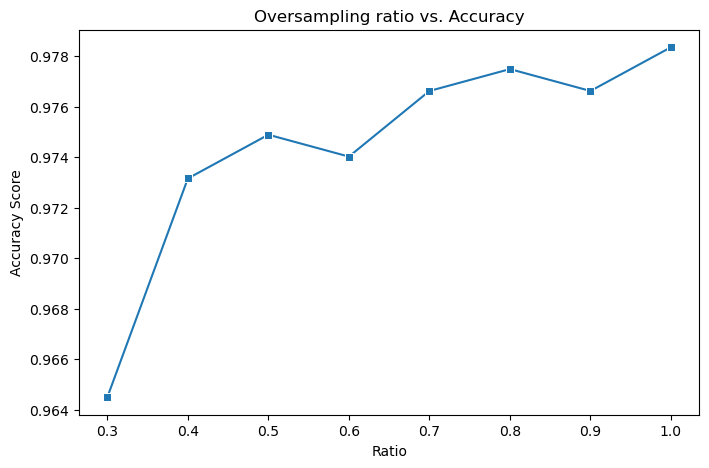

In [70]:
fig, ax = plt.subplots(figsize=(8,5))
sns.lineplot(x=ratio_list, y=acc_list, marker="s", ax=ax)
ax.set_xlabel("Ratio")
ax.set_ylabel("Accuracy Score")
ax.set_title("Oversampling ratio vs. Accuracy")

In [71]:
ratio_list = [.7, .75, .8, .85, .9, .95, 1]
print("Testing different oversampling ratios:")
for ratio in ratio_list:
    acc = lr_with_oversampling(df_cleaning, sample_ratio=ratio)
    print(f"Ratio {ratio} Accuracy: {acc}")

Testing different oversampling ratios:
Ratio 0.7 Accuracy: 0.9766233766233766
Ratio 0.75 Accuracy: 0.9774891774891775
Ratio 0.8 Accuracy: 0.9774891774891775
Ratio 0.85 Accuracy: 0.9766233766233766
Ratio 0.9 Accuracy: 0.9766233766233766
Ratio 0.95 Accuracy: 0.9766233766233766
Ratio 1 Accuracy: 0.9783549783549783


It seems that as the sampling ratio gets higher, the model accuracy also increases, with it peaking at a sampling ratio of 1:1

Let's now look at different C-values

In [72]:
c_list = [10e-3, 10e-2, 1, 10, 100, 10e2, 10e3, 10e4]
print("Testing different C values:")
acc_list = []

for c in c_list:
    acc = lr_with_oversampling(df_cleaning, c_value=c)
    acc_list.append(acc)
    print(f"C value = {c} accuracy: {acc}")

Testing different C values:
C value = 0.01 accuracy: 0.9532467532467532
C value = 0.1 accuracy: 0.9653679653679653
C value = 1 accuracy: 0.9783549783549783
C value = 10 accuracy: 0.9809523809523809
C value = 100 accuracy: 0.9800865800865801
C value = 1000.0 accuracy: 0.9800865800865801
C value = 10000.0 accuracy: 0.9800865800865801
C value = 100000.0 accuracy: 0.9800865800865801


Text(0.5, 1.0, 'C-value vs. Accuracy')

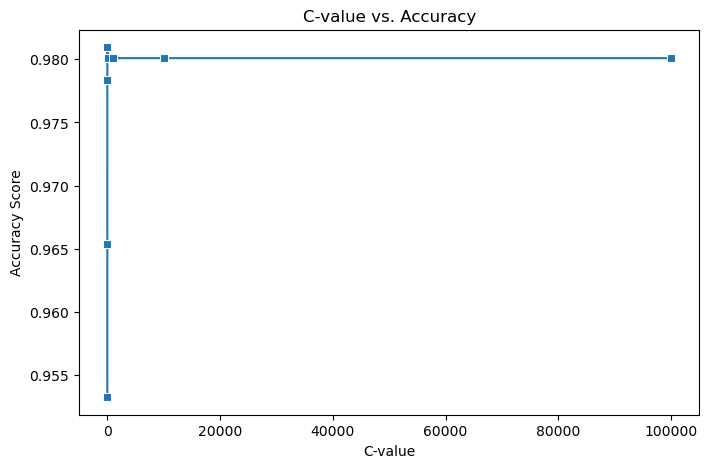

In [73]:
fig, ax = plt.subplots(figsize=(8,5))
sns.lineplot(x=c_list, y=acc_list, marker="s", ax=ax)
ax.set_xlabel("C-value")
ax.set_ylabel("Accuracy Score")
ax.set_title("C-value vs. Accuracy")

In [74]:
c_list = np.linspace(1, 100, 100).tolist()
print("Testing different C values:")
acc_list = []

for c in c_list:
    acc = lr_with_oversampling(df_cleaning, c_value=c)
    acc_list.append(acc)
    print(f"C value = {c} accuracy: {acc}")

print(f"Best accuracy: {max(acc_list)} at c-value {acc_list.index(max(acc_list)) + 1}")

Testing different C values:
C value = 1.0 accuracy: 0.9783549783549783
C value = 2.0 accuracy: 0.9792207792207792
C value = 3.0 accuracy: 0.9792207792207792
C value = 4.0 accuracy: 0.9783549783549783
C value = 5.0 accuracy: 0.9792207792207792
C value = 6.0 accuracy: 0.9800865800865801
C value = 7.0 accuracy: 0.9809523809523809
C value = 8.0 accuracy: 0.9809523809523809
C value = 9.0 accuracy: 0.9809523809523809
C value = 10.0 accuracy: 0.9809523809523809
C value = 11.0 accuracy: 0.9809523809523809
C value = 12.0 accuracy: 0.9809523809523809
C value = 13.0 accuracy: 0.9809523809523809
C value = 14.0 accuracy: 0.9818181818181818
C value = 15.0 accuracy: 0.9809523809523809
C value = 16.0 accuracy: 0.9809523809523809
C value = 17.0 accuracy: 0.9809523809523809
C value = 18.0 accuracy: 0.9818181818181818
C value = 19.0 accuracy: 0.9818181818181818
C value = 20.0 accuracy: 0.9792207792207792
C value = 21.0 accuracy: 0.9792207792207792
C value = 22.0 accuracy: 0.9792207792207792
C value = 23.

Here, we can see that the best c-value is 14

Text(-27, 0.9818, 'Accuracy = .9818')

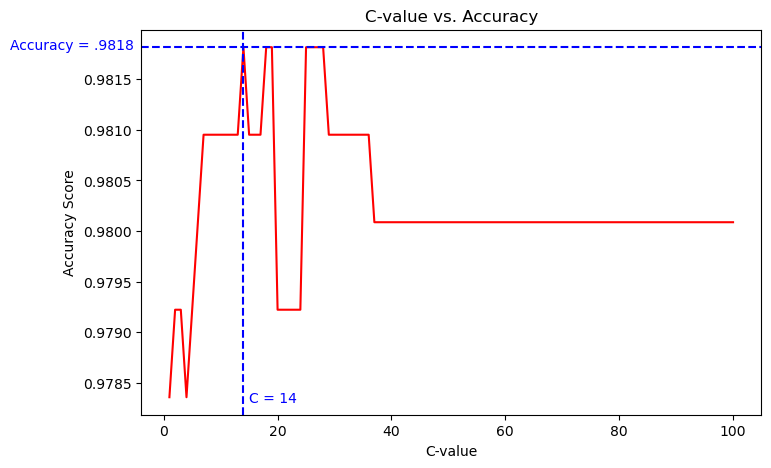

In [75]:
fig, ax = plt.subplots(figsize=(8,5))
sns.lineplot(x=c_list, y=acc_list, ax=ax, color='r')
ax.set_xlabel("C-value")
ax.set_ylabel("Accuracy Score")
ax.set_title("C-value vs. Accuracy")
plt.axvline(14, ls='--', color="b")
plt.text(15,.9783,'C = 14',rotation=0, color="b")
plt.axhline(0.9818181818181818, ls='--', color="b")
plt.text(-27,.9818,'Accuracy = .9818',rotation=0, color="b")

Through our experiment, we determined that a C-Value of 14 is best

Let's tune the min_df parameter of TfidfVectorizer. This parameter dictates how many entries a given word has to occur in a dataset in order for it to be scored.

In [76]:
mindf_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 13, 14, 15, 20, 25, 30, 35, 40, 45, 50]
print("Testing different min_df values:")
acc_list = []

for mindf in mindf_list:
    acc = lr_with_oversampling(df_cleaning, custom_min_df=mindf)
    acc_list.append(acc)
    print(f"min_df value = {mindf} accuracy: {acc}")

Testing different min_df values:
min_df value = 1 accuracy: 0.9783549783549783
min_df value = 2 accuracy: 0.9766233766233766
min_df value = 3 accuracy: 0.9774891774891775
min_df value = 4 accuracy: 0.974025974025974
min_df value = 5 accuracy: 0.974025974025974
min_df value = 6 accuracy: 0.9748917748917749
min_df value = 7 accuracy: 0.9748917748917749
min_df value = 8 accuracy: 0.9688311688311688
min_df value = 9 accuracy: 0.9670995670995671
min_df value = 12 accuracy: 0.9567099567099567
min_df value = 13 accuracy: 0.9567099567099567
min_df value = 14 accuracy: 0.9575757575757575
min_df value = 15 accuracy: 0.9549783549783549
min_df value = 20 accuracy: 0.9506493506493506
min_df value = 25 accuracy: 0.9437229437229437
min_df value = 30 accuracy: 0.941991341991342
min_df value = 35 accuracy: 0.9393939393939394
min_df value = 40 accuracy: 0.9367965367965368
min_df value = 45 accuracy: 0.9316017316017317
min_df value = 50 accuracy: 0.9177489177489178


Text(0.5, 1.0, 'Vectorizer min_df parameter vs. Accuracy')

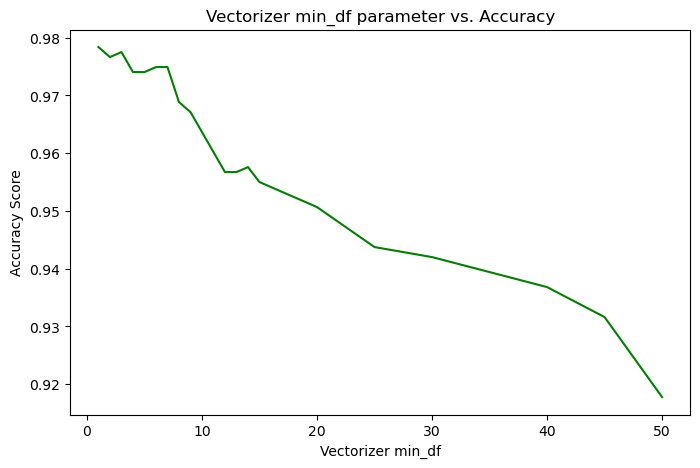

In [77]:
fig, ax = plt.subplots(figsize=(8,5))
sns.lineplot(x=mindf_list, y=acc_list, ax=ax, color='green')
ax.set_xlabel("Vectorizer min_df")
ax.set_ylabel("Accuracy Score")
ax.set_title("Vectorizer min_df parameter vs. Accuracy")

Our testing shows that a min_df value of 1 is optimal, with the model accuracy decreasing as this parameter increases

With these 3 parameters, let's make our final model

Accuracy =  0.9818181818181818
Recall =  0.9193548387096774
Precision =  0.9661016949152542
F1 Score =  0.9421487603305785
Confusion Matrix:


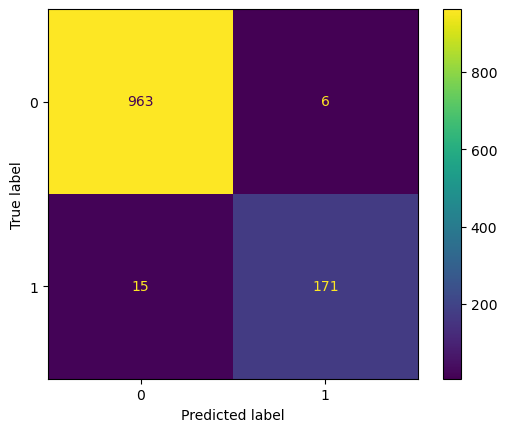

In [104]:
X_train, X_test, y_train, y_test = train_test_split(df_cleaning['message_lemmatized'], df_cleaning['Category'], test_size=.2, random_state=42)

tfidf_vectorizer = TfidfVectorizer(min_df=1)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

sm = SMOTE(random_state=42, sampling_strategy=1.0)
X_oversamp, y_oversamp = sm.fit_resample(X_train_tfidf, y_train)

logreg = LogisticRegression(random_state=42, max_iter=10000, C=14)
logreg.fit(X_oversamp, y_oversamp)

y_pred_lr = logreg.predict(X_test_tfidf)

print(f"Accuracy = ", accuracy_score(y_test, y_pred_lr))
print(f"Recall = ", recall_score(y_test, y_pred_lr))
print(f"Precision = ", precision_score(y_test, y_pred_lr))
print(f"F1 Score = ", f1_score(y_test, y_pred_lr))
print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred_lr)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

After adjusting these parameters, our model scores much better for recall, precision, and F1 score. This means that we've minimized the number of false positives and negatives, making the model much more accurate than before.

# Multinominal Naive Bayes

In [79]:
# Load data 
import pandas as pd
data = pd.read_csv("./data/SMSSpamCollection", sep="\t", names=["label", "text"])

# Preprocess
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(lowercase=True, stop_words="english")
X = vectorizer.fit_transform(data["text"])
y = data["label"]

# Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model (Naive Bayes)
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB()
model.fit(X_train, y_train)

# Evaluate
accuracy = model.score(X_test, y_test)
print(f"Accuracy: {accuracy}")

Accuracy: 0.979372197309417


Accuracy: 0.979372197309417


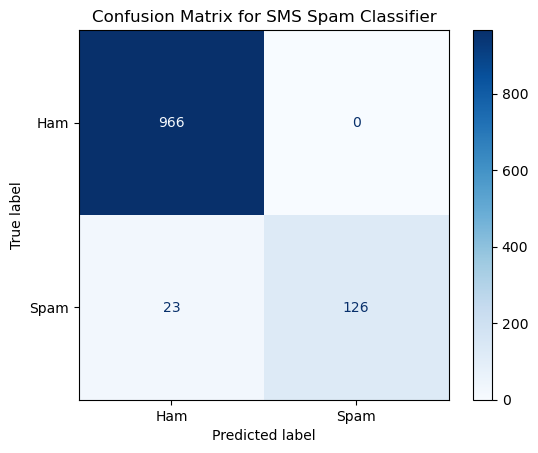

In [80]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Load data
data = pd.read_csv('./data/SMSSpamCollection', sep='\t', names=['label', 'text'])

# Preprocess: Convert spam labels to binary (0 = ham, 1 = spam)
data['label'] = data['label'].map({'ham': 0, 'spam': 1})

# Vectorize the text using TF-IDF
vectorizer = TfidfVectorizer(lowercase=True, stop_words='english')
X = vectorizer.fit_transform(data['text'])
y = data['label']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model (Naive Bayes)
model = MultinomialNB()
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = model.score(X_test, y_test)
print(f"Accuracy: {accuracy}")

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Ham', 'Spam'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for SMS Spam Classifier')
plt.show()

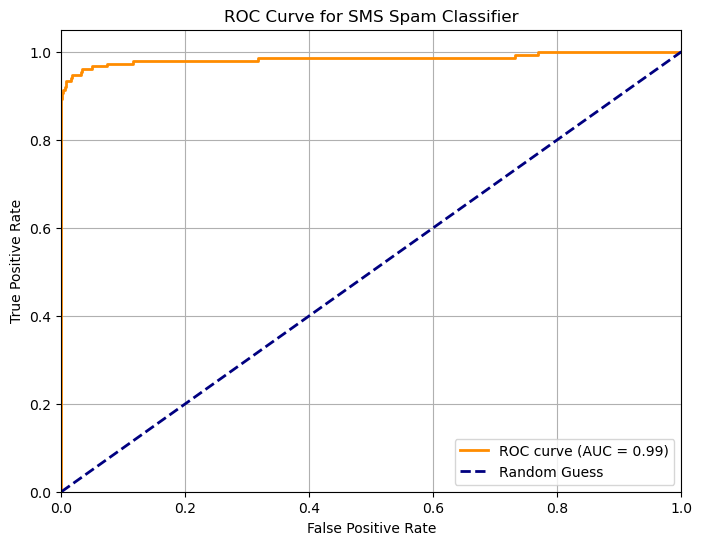

Accuracy: 0.979372197309417


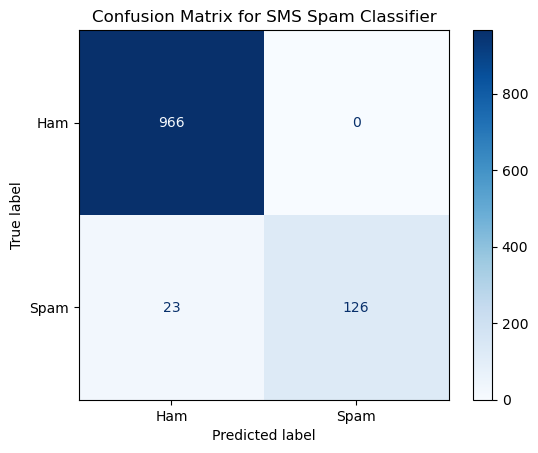

In [81]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import matplotlib.pyplot as plt

# Load data
data = pd.read_csv('./data/SMSSpamCollection', sep='\t', names=['label', 'text'])

# Preprocess: Convert spam labels to binary (0 = ham, 1 = spam)
data['label'] = data['label'].map({'ham': 0, 'spam': 1})

# Vectorize the text using TF-IDF
vectorizer = TfidfVectorizer(lowercase=True, stop_words='english')
X = vectorizer.fit_transform(data['text'])
y = data['label']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model (Naive Bayes)
model = MultinomialNB()
model.fit(X_train, y_train)

# Predict probabilities (needed for ROC)
y_prob = model.predict_proba(X_test)[:, 1]  # Probability of being spam (class 1)

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for SMS Spam Classifier')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Print accuracy and confusion matrix for reference
y_pred = model.predict(X_test)
accuracy = model.score(X_test, y_test)
print(f"Accuracy: {accuracy}")
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Ham', 'Spam'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for SMS Spam Classifier')
plt.show()

Accuracy: 0.979372197309417


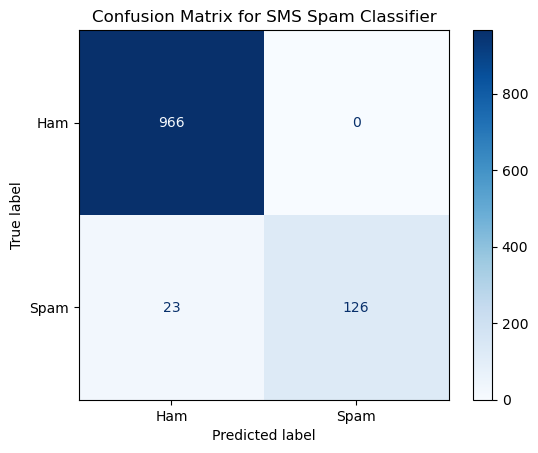

False Negatives (Missed Spam):
1: Guess what! Somebody you know secretly fancies you! Wanna find out who it is? Give us a call on 09065394973 from Landline DATEBox1282EssexCM61XN 150p/min 18
2: Oh my god! I've found your number again! I'm so glad, text me back xafter this msgs cst std ntwk chg £1.50
3: Your next amazing xxx PICSFREE1 video will be sent to you enjoy! If one vid is not enough for 2day text back the keyword PICSFREE1 to get the next video.
4: Babe: U want me dont u baby! Im nasty and have a thing 4 filthyguys. Fancy a rude time with a sexy bitch. How about we go slo n hard! Txt XXX SLO(4msgs)
5: I want some cock! My hubby's away, I need a real man 2 satisfy me. Txt WIFE to 89938 for no strings action. (Txt STOP 2 end, txt rec £1.50ea. OTBox 731 LA1 7WS. )
6: Hello darling how are you today? I would love to have a chat, why dont you tell me what you look like and what you are in to sexy?
7: Guess what! Somebody you know secretly fancies you! Wanna find out who it is? Give 

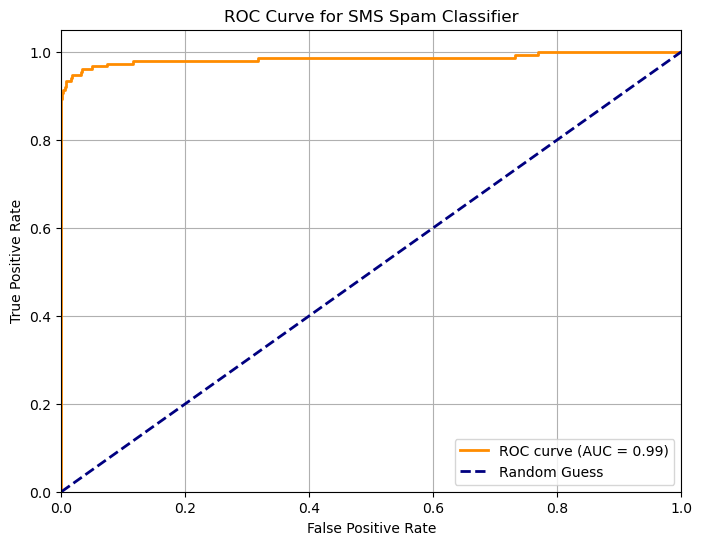

In [82]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import matplotlib.pyplot as plt

# Load data
data = pd.read_csv('./data/SMSSpamCollection', sep='\t', names=['label', 'text'])

# Preprocess: Convert spam labels to binary (0 = ham, 1 = spam)
data['label'] = data['label'].map({'ham': 0, 'spam': 1})

# Vectorize the text using TF-IDF
vectorizer = TfidfVectorizer(lowercase=True, stop_words='english')
X = vectorizer.fit_transform(data['text'])
y = data['label']

# Split the data, keeping track of original indices
train_indices, test_indices = train_test_split(np.arange(len(data)), test_size=0.2, random_state=42)
X_train = X[train_indices]
X_test = X[test_indices]
y_train = y[train_indices]
y_test = y[test_indices]

# Train the model
model = MultinomialNB()
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)
accuracy = model.score(X_test, y_test)
print(f"Accuracy: {accuracy}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Ham', 'Spam'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for SMS Spam Classifier')
plt.show()

# Extract false negatives
fn_indices = np.where((y_test == 1) & (y_pred == 0))[0]  # Indices in test set
fn_original_indices = test_indices[fn_indices]  # Map to original dataset indices

# Extract the false negative texts
fn_texts = data.iloc[fn_original_indices]['text'].values

# Print false negatives
print("False Negatives (Missed Spam):")
for i, text in enumerate(fn_texts):
    print(f"{i+1}: {text}")

# Generate ROC curve
y_prob = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for SMS Spam Classifier')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

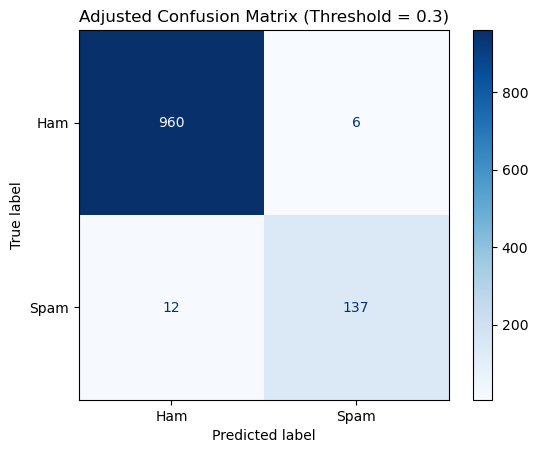

In [83]:
y_prob = model.predict_proba(X_test)[:, 1]
y_pred_adjusted = (y_prob > 0.3).astype(int)
cm_adjusted = confusion_matrix(y_test, y_pred_adjusted, labels=[0, 1])
disp_adjusted = ConfusionMatrixDisplay(confusion_matrix=cm_adjusted, display_labels=['Ham', 'Spam'])
disp_adjusted.plot(cmap=plt.cm.Blues)
plt.title('Adjusted Confusion Matrix (Threshold = 0.3)')
plt.show()

In [84]:
fp_indices = np.where((y_test == 0) & (y_pred_adjusted == 1))[0]
fp_original_indices = test_indices[fp_indices]
fp_texts = data.iloc[fp_original_indices]['text'].values
print("False Positives (Misclassified Ham):")
for i, text in enumerate(fp_texts):
    print(f"{i+1}: {text}")

False Positives (Misclassified Ham):
1: Nutter. Cutter. Ctter. Cttergg. Cttargg. Ctargg. Ctagg. ie you
2: How much would it cost to hire a hitman
3: K:)eng rocking in ashes:)
4: Ultimately tor motive tui achieve korli.
5: No. She's currently in scotland for that.
6: K..i deleted my contact that why?


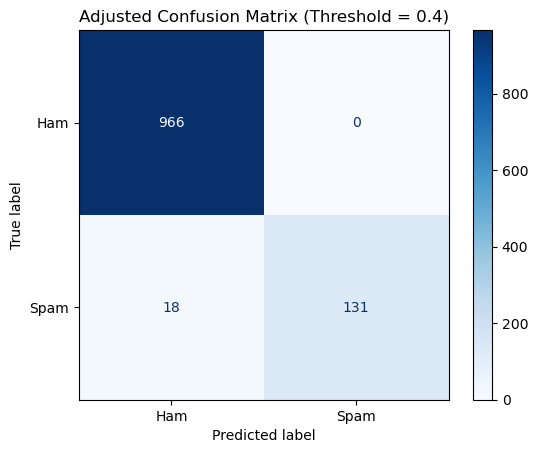

In [85]:
y_prob = model.predict_proba(X_test)[:, 1]
y_pred_adjusted = (y_prob > 0.4).astype(int)
cm_adjusted = confusion_matrix(y_test, y_pred_adjusted, labels=[0, 1])
disp_adjusted = ConfusionMatrixDisplay(confusion_matrix=cm_adjusted, display_labels=['Ham', 'Spam'])
disp_adjusted.plot(cmap=plt.cm.Blues)
plt.title('Adjusted Confusion Matrix (Threshold = 0.4)')
plt.show()

Accuracy (Default Threshold): 0.9596412556053812
Accuracy (Threshold 0.4): 0.9739910313901345


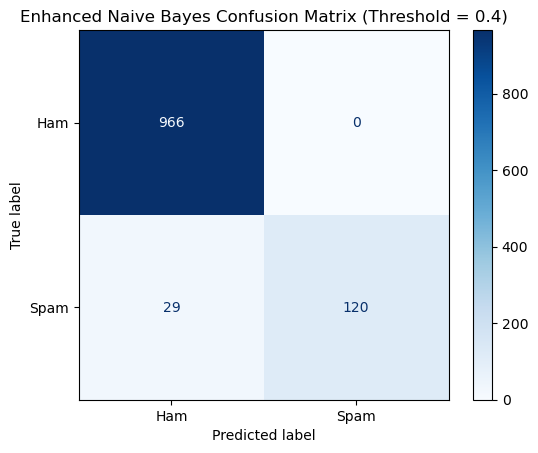

False Negatives with Enhanced Naive Bayes (Threshold 0.4):
1: Reminder: You have not downloaded the content you have already paid for. Goto http://doit. mymoby. tv/ to collect your content.
2: Guess what! Somebody you know secretly fancies you! Wanna find out who it is? Give us a call on 09065394973 from Landline DATEBox1282EssexCM61XN 150p/min 18
3: Oh my god! I've found your number again! I'm so glad, text me back xafter this msgs cst std ntwk chg £1.50
4: Your next amazing xxx PICSFREE1 video will be sent to you enjoy! If one vid is not enough for 2day text back the keyword PICSFREE1 to get the next video.
5: Rock yr chik. Get 100's of filthy films &XXX pics on yr phone now. rply FILTH to 69669. Saristar Ltd, E14 9YT 08701752560. 450p per 5 days. Stop2 cancel
6: Babe: U want me dont u baby! Im nasty and have a thing 4 filthyguys. Fancy a rude time with a sexy bitch. How about we go slo n hard! Txt XXX SLO(4msgs)
7: I want some cock! My hubby's away, I need a real man 2 satisfy me. T

In [86]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Load and preprocess data
data = pd.read_csv('./data/SMSSpamCollection', sep='\t', names=['label', 'text'])
data['label'] = data['label'].map({'ham': 0, 'spam': 1})

# Vectorize the text with n-grams
vectorizer = TfidfVectorizer(lowercase=True, stop_words='english', ngram_range=(1, 2))
X = vectorizer.fit_transform(data['text'])
y = data['label']

# Split data with tracked indices
train_indices, test_indices = train_test_split(np.arange(len(data)), test_size=0.2, random_state=42)
X_train, X_test = X[train_indices], X[test_indices]
y_train, y_test = y[train_indices], y[test_indices]

# Train the model
model = MultinomialNB()
model.fit(X_train, y_train)

# Predict with adjusted threshold (0.4)
y_prob = model.predict_proba(X_test)[:, 1]  # Probability of being spam
y_pred = (y_prob > 0.4).astype(int)  # Apply 0.4 threshold

# Evaluate accuracy
accuracy = model.score(X_test, y_test)
print(f"Accuracy (Default Threshold): {accuracy}")
print(f"Accuracy (Threshold 0.4): {(y_pred == y_test).mean()}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Ham', 'Spam'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Enhanced Naive Bayes Confusion Matrix (Threshold = 0.4)')
plt.show()

# Extract false negatives
fn_indices = np.where((y_test == 1) & (y_pred == 0))[0]
fn_original_indices = test_indices[fn_indices]
fn_texts = data.iloc[fn_original_indices]['text'].values
print("False Negatives with Enhanced Naive Bayes (Threshold 0.4):")
for i, text in enumerate(fn_texts):
    print(f"{i+1}: {text}")

Accuracy (Threshold 0.4): 0.9856502242152466


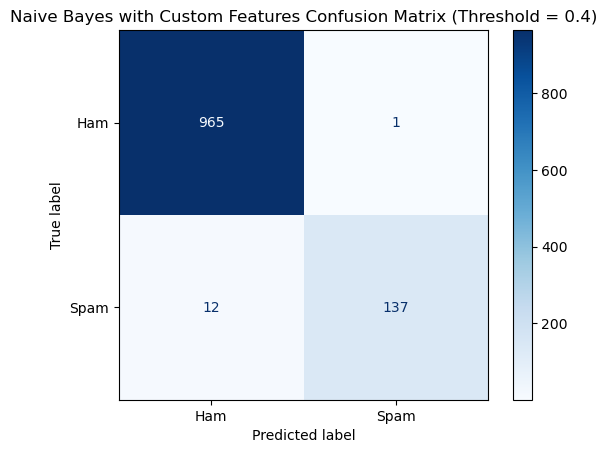

False Negatives with Custom Features (Threshold 0.4):
1: Oh my god! I've found your number again! I'm so glad, text me back xafter this msgs cst std ntwk chg £1.50
2: Your next amazing xxx PICSFREE1 video will be sent to you enjoy! If one vid is not enough for 2day text back the keyword PICSFREE1 to get the next video.
3: Babe: U want me dont u baby! Im nasty and have a thing 4 filthyguys. Fancy a rude time with a sexy bitch. How about we go slo n hard! Txt XXX SLO(4msgs)
4: I want some cock! My hubby's away, I need a real man 2 satisfy me. Txt WIFE to 89938 for no strings action. (Txt STOP 2 end, txt rec £1.50ea. OTBox 731 LA1 7WS. )
5: Hello darling how are you today? I would love to have a chat, why dont you tell me what you look like and what you are in to sexy?
6: Do you realize that in about 40 years, we'll have thousands of old ladies running around with tattoos?
7: Will u meet ur dream partner soon? Is ur career off 2 a flyng start? 2 find out free, txt HORO followed by ur star

In [87]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import re

# Load and preprocess data
data = pd.read_csv('./data/SMSSpamCollection', sep='\t', names=['label', 'text'])
data['label'] = data['label'].map({'ham': 0, 'spam': 1})

# Vectorize the text (unigrams only for now)
vectorizer = TfidfVectorizer(lowercase=True, stop_words='english')
X = vectorizer.fit_transform(data['text'])
y = data['label']

# Add custom features (phone and URL detection)
def extract_features(text):
    phone = int(bool(re.search(r'\b\d{3}\d{6,}\b', text)))  # Matches 0906123456 etc.
    url = int(bool(re.search(r'http[s]?://\S+', text)))     # Matches http://...
    return [phone, url]

features = np.array([extract_features(t) for t in data['text']])
X_custom = np.hstack((X.toarray(), features))  # Combine TF-IDF and custom features

# Split data with tracked indices
train_indices, test_indices = train_test_split(np.arange(len(data)), test_size=0.2, random_state=42)
X_train_custom, X_test_custom = X_custom[train_indices], X_custom[test_indices]
y_train, y_test = y[train_indices], y[test_indices]

# Train the model
model = MultinomialNB()
model.fit(X_train_custom, y_train)

# Predict with 0.4 threshold
y_prob = model.predict_proba(X_test_custom)[:, 1]
y_pred = (y_prob > 0.4).astype(int)

# Evaluate accuracy
accuracy = model.score(X_test_custom, y_test)
print(f"Accuracy (Threshold 0.4): {accuracy}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Ham', 'Spam'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Naive Bayes with Custom Features Confusion Matrix (Threshold = 0.4)')
plt.show()

# Extract false negatives
fn_indices = np.where((y_test == 1) & (y_pred == 0))[0]
fn_original_indices = test_indices[fn_indices]
fn_texts = data.iloc[fn_original_indices]['text'].values
print("False Negatives with Custom Features (Threshold 0.4):")
for i, text in enumerate(fn_texts):
    print(f"{i+1}: {text}")

Accuracy (Threshold 0.4): 0.9883408071748879


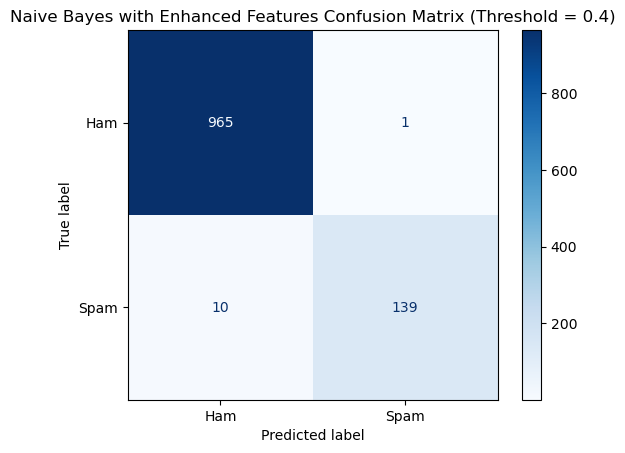

False Negatives with Enhanced Features (Threshold 0.4):
1: Your next amazing xxx PICSFREE1 video will be sent to you enjoy! If one vid is not enough for 2day text back the keyword PICSFREE1 to get the next video.
2: Babe: U want me dont u baby! Im nasty and have a thing 4 filthyguys. Fancy a rude time with a sexy bitch. How about we go slo n hard! Txt XXX SLO(4msgs)
3: Hello darling how are you today? I would love to have a chat, why dont you tell me what you look like and what you are in to sexy?
4: Do you realize that in about 40 years, we'll have thousands of old ladies running around with tattoos?
5: Will u meet ur dream partner soon? Is ur career off 2 a flyng start? 2 find out free, txt HORO followed by ur star sign, e. g. HORO ARIES
6: Talk sexy!! Make new friends or fall in love in the worlds most discreet text dating service. Just text VIP to 83110 and see who you could meet.
7: You won't believe it but it's true. It's Incredible Txts! Reply G now to learn truly amazing things

In [88]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import re

# Load and preprocess data
data = pd.read_csv('./data/SMSSpamCollection', sep='\t', names=['label', 'text'])
data['label'] = data['label'].map({'ham': 0, 'spam': 1})

# Vectorize the text (unigrams only)
vectorizer = TfidfVectorizer(lowercase=True, stop_words='english')
X = vectorizer.fit_transform(data['text'])
y = data['label']

# Add custom features (phone, URL, price, short code)
def extract_features(text):
    phone = int(bool(re.search(r'\b\d{3}\d{6,}\b', text)))  # Matches 0906123456 etc.
    url = int(bool(re.search(r'http[s]?://\S+', text)))     # Matches http://...
    price = int(bool(re.search(r'£\d+|\d+p/min|\d+p/day', text)))  # Matches £1.50, 150p/min
    short_code = int(bool(re.search(r'TXT to \d+', text)))   # Matches TXT to 80160
    return [phone, url, price, short_code]

features = np.array([extract_features(t) for t in data['text']])
X_custom = np.hstack((X.toarray(), features))  # Combine TF-IDF and custom features

# Split data with tracked indices
train_indices, test_indices = train_test_split(np.arange(len(data)), test_size=0.2, random_state=42)
X_train_custom, X_test_custom = X_custom[train_indices], X_custom[test_indices]
y_train, y_test = y[train_indices], y[test_indices]

# Train the model
model = MultinomialNB()
model.fit(X_train_custom, y_train)

# Predict with 0.4 threshold
y_prob = model.predict_proba(X_test_custom)[:, 1]
y_pred = (y_prob > 0.4).astype(int)

# Evaluate accuracy
accuracy = model.score(X_test_custom, y_test)
print(f"Accuracy (Threshold 0.4): {accuracy}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Ham', 'Spam'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Naive Bayes with Enhanced Features Confusion Matrix (Threshold = 0.4)')
plt.show()

# Extract false negatives
fn_indices = np.where((y_test == 1) & (y_pred == 0))[0]
fn_original_indices = test_indices[fn_indices]
fn_texts = data.iloc[fn_original_indices]['text'].values
print("False Negatives with Enhanced Features (Threshold 0.4):")
for i, text in enumerate(fn_texts):
    print(f"{i+1}: {text}")

Accuracy (Threshold 0.4): 0.9426008968609866


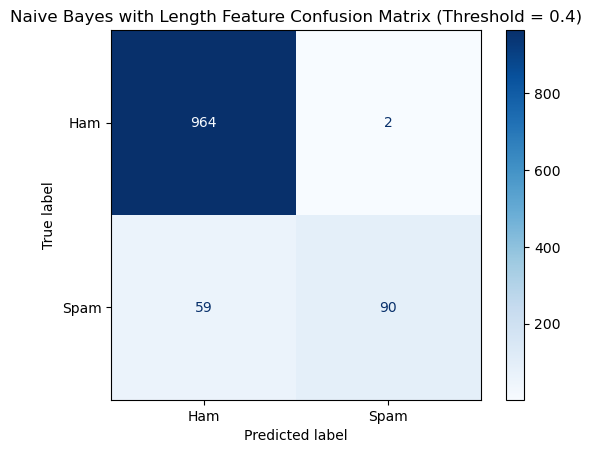

False Negatives with Length Feature (Threshold 0.4):
1: FREE RINGTONE text FIRST to 87131 for a poly or text GET to 87131 for a true tone! Help? 0845 2814032 16 after 1st free, tones are 3x£150pw to e£nd txt stop
2: Reminder: You have not downloaded the content you have already paid for. Goto http://doit. mymoby. tv/ to collect your content.
3: 8007 FREE for 1st week! No1 Nokia tone 4 ur mob every week just txt NOKIA to 8007 Get txting and tell ur mates www.getzed.co.uk POBox 36504 W4 5WQ norm 150p/tone 16+
4: This message is free. Welcome to the new & improved Sex & Dogging club! To unsubscribe from this service reply STOP. msgs@150p 18 only
5: T-Mobile customer you may now claim your FREE CAMERA PHONE upgrade & a pay & go sim card for your loyalty. Call on 0845 021 3680.Offer ends 28thFeb.T&C's apply
6: Oh my god! I've found your number again! I'm so glad, text me back xafter this msgs cst std ntwk chg £1.50
7: Your next amazing xxx PICSFREE1 video will be sent to you enjoy! If one v

In [89]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import re

# Load and preprocess data
data = pd.read_csv('./data/SMSSpamCollection', sep='\t', names=['label', 'text'])
data['label'] = data['label'].map({'ham': 0, 'spam': 1})

# Vectorize the text (unigrams only)
vectorizer = TfidfVectorizer(lowercase=True, stop_words='english')
X = vectorizer.fit_transform(data['text'])
y = data['label']

# Add custom features (phone, URL, price, short code, length)
def extract_features(text):
    phone = int(bool(re.search(r'\b\d{3}\d{6,}\b', text)))
    url = int(bool(re.search(r'http[s]?://\S+', text)))
    price = int(bool(re.search(r'£\d+|\d+p/min|\d+p/day', text)))
    short_code = int(bool(re.search(r'TXT to \d+', text)))
    length = len(text.split())  # Number of words
    return [phone, url, price, short_code, length]

features = np.array([extract_features(t) for t in data['text']])
X_custom = np.hstack((X.toarray(), features))  # Combine TF-IDF and custom features

# Split data with tracked indices
train_indices, test_indices = train_test_split(np.arange(len(data)), test_size=0.2, random_state=42)
X_train_custom, X_test_custom = X_custom[train_indices], X_custom[test_indices]
y_train, y_test = y[train_indices], y[test_indices]

# Train the model
model = MultinomialNB()
model.fit(X_train_custom, y_train)

# Predict with 0.4 threshold
y_prob = model.predict_proba(X_test_custom)[:, 1]
y_pred = (y_prob > 0.4).astype(int)

# Evaluate accuracy
accuracy = model.score(X_test_custom, y_test)
print(f"Accuracy (Threshold 0.4): {accuracy}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Ham', 'Spam'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Naive Bayes with Length Feature Confusion Matrix (Threshold = 0.4)')
plt.show()

# Extract false negatives
fn_indices = np.where((y_test == 1) & (y_pred == 0))[0]
fn_original_indices = test_indices[fn_indices]
fn_texts = data.iloc[fn_original_indices]['text'].values
print("False Negatives with Length Feature (Threshold 0.4):")
for i, text in enumerate(fn_texts):
    print(f"{i+1}: {text}")

Accuracy (Threshold 0.38): 0.9883408071748879


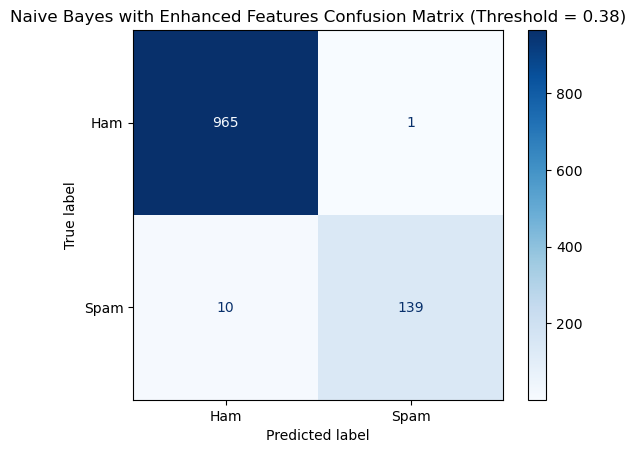

False Negatives with Enhanced Features (Threshold 0.38):
1: Your next amazing xxx PICSFREE1 video will be sent to you enjoy! If one vid is not enough for 2day text back the keyword PICSFREE1 to get the next video.
2: Babe: U want me dont u baby! Im nasty and have a thing 4 filthyguys. Fancy a rude time with a sexy bitch. How about we go slo n hard! Txt XXX SLO(4msgs)
3: Hello darling how are you today? I would love to have a chat, why dont you tell me what you look like and what you are in to sexy?
4: Do you realize that in about 40 years, we'll have thousands of old ladies running around with tattoos?
5: Will u meet ur dream partner soon? Is ur career off 2 a flyng start? 2 find out free, txt HORO followed by ur star sign, e. g. HORO ARIES
6: Talk sexy!! Make new friends or fall in love in the worlds most discreet text dating service. Just text VIP to 83110 and see who you could meet.
7: You won't believe it but it's true. It's Incredible Txts! Reply G now to learn truly amazing thing

In [90]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import re

# Load and preprocess data
data = pd.read_csv('./data/SMSSpamCollection', sep='\t', names=['label', 'text'])
data['label'] = data['label'].map({'ham': 0, 'spam': 1})

# Vectorize the text (unigrams only)
vectorizer = TfidfVectorizer(lowercase=True, stop_words='english')
X = vectorizer.fit_transform(data['text'])
y = data['label']

# Add custom features (phone, URL, price, short code)
def extract_features(text):
    phone = int(bool(re.search(r'\b\d{3}\d{6,}\b', text)))
    url = int(bool(re.search(r'http[s]?://\S+', text)))
    price = int(bool(re.search(r'£\d+|\d+p/min|\d+p/day', text)))
    short_code = int(bool(re.search(r'TXT to \d+', text)))
    return [phone, url, price, short_code]

features = np.array([extract_features(t) for t in data['text']])
X_custom = np.hstack((X.toarray(), features))  # Combine TF-IDF and custom features

# Split data with tracked indices
train_indices, test_indices = train_test_split(np.arange(len(data)), test_size=0.2, random_state=42)
X_train_custom, X_test_custom = X_custom[train_indices], X_custom[test_indices]
y_train, y_test = y[train_indices], y[test_indices]

# Train the model
model = MultinomialNB()
model.fit(X_train_custom, y_train)

# Predict with 0.38 threshold
y_prob = model.predict_proba(X_test_custom)[:, 1]
y_pred = (y_prob > 0.38).astype(int)

# Evaluate accuracy
accuracy = model.score(X_test_custom, y_test)
print(f"Accuracy (Threshold 0.38): {accuracy}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Ham', 'Spam'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Naive Bayes with Enhanced Features Confusion Matrix (Threshold = 0.38)')
plt.show()

# Extract false negatives
fn_indices = np.where((y_test == 1) & (y_pred == 0))[0]
fn_original_indices = test_indices[fn_indices]
fn_texts = data.iloc[fn_original_indices]['text'].values
print("False Negatives with Enhanced Features (Threshold 0.38):")
for i, text in enumerate(fn_texts):
    print(f"{i+1}: {text}")

Accuracy (Threshold 0.38): 0.9901345291479821


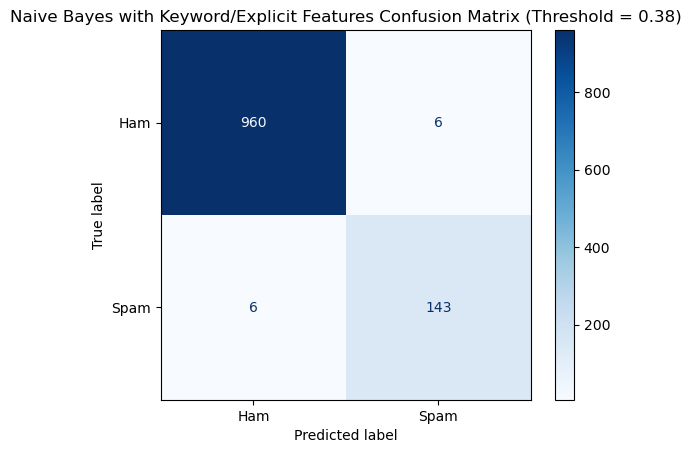

False Negatives with Keyword/Explicit Features (Threshold 0.38):
1: Your next amazing xxx PICSFREE1 video will be sent to you enjoy! If one vid is not enough for 2day text back the keyword PICSFREE1 to get the next video.
2: Babe: U want me dont u baby! Im nasty and have a thing 4 filthyguys. Fancy a rude time with a sexy bitch. How about we go slo n hard! Txt XXX SLO(4msgs)
3: Hello darling how are you today? I would love to have a chat, why dont you tell me what you look like and what you are in to sexy?
4: Do you realize that in about 40 years, we'll have thousands of old ladies running around with tattoos?
5: Talk sexy!! Make new friends or fall in love in the worlds most discreet text dating service. Just text VIP to 83110 and see who you could meet.
6: Burger King - Wanna play footy at a top stadium? Get 2 Burger King before 1st Sept and go Large or Super with Coca-Cola and walk out a winner


In [91]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import re

# Load and preprocess data
data = pd.read_csv('./data/SMSSpamCollection', sep='\t', names=['label', 'text'])
data['label'] = data['label'].map({'ham': 0, 'spam': 1})

# Vectorize the text (unigrams only)
vectorizer = TfidfVectorizer(lowercase=True, stop_words='english')
X = vectorizer.fit_transform(data['text'])
y = data['label']

# Add custom features (phone, URL, price, short code, keywords, explicit)
def extract_features(text):
    phone = int(bool(re.search(r'\b\d{3}\d{6,}\b', text)))
    url = int(bool(re.search(r'http[s]?://\S+', text)))
    price = int(bool(re.search(r'£\d+|\d+p/min|\d+p/day', text)))
    short_code = int(bool(re.search(r'TXT to \d+', text)))
    keywords = len(re.findall(r'\b(free|win|txt|call)\b', text, re.I))  # Case-insensitive
    explicit = int(bool(re.search(r'xxx|sexy|nasty|cock', text, re.I)))
    return [phone, url, price, short_code, keywords, explicit]

features = np.array([extract_features(t) for t in data['text']])
X_custom = np.hstack((X.toarray(), features))  # Combine TF-IDF and custom features

# Split data with tracked indices
train_indices, test_indices = train_test_split(np.arange(len(data)), test_size=0.2, random_state=42)
X_train_custom, X_test_custom = X_custom[train_indices], X_custom[test_indices]
y_train, y_test = y[train_indices], y[test_indices]

# Train the model
model = MultinomialNB()
model.fit(X_train_custom, y_train)

# Predict with 0.38 threshold
y_prob = model.predict_proba(X_test_custom)[:, 1]
y_pred = (y_prob > 0.38).astype(int)

# Evaluate accuracy
accuracy = model.score(X_test_custom, y_test)
print(f"Accuracy (Threshold 0.38): {accuracy}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Ham', 'Spam'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Naive Bayes with Keyword/Explicit Features Confusion Matrix (Threshold = 0.38)')
plt.show()

# Extract false negatives
fn_indices = np.where((y_test == 1) & (y_pred == 0))[0]
fn_original_indices = test_indices[fn_indices]
fn_texts = data.iloc[fn_original_indices]['text'].values
print("False Negatives with Keyword/Explicit Features (Threshold 0.38):")
for i, text in enumerate(fn_texts):
    print(f"{i+1}: {text}")

Accuracy (Threshold 0.40): 0.9901345291479821


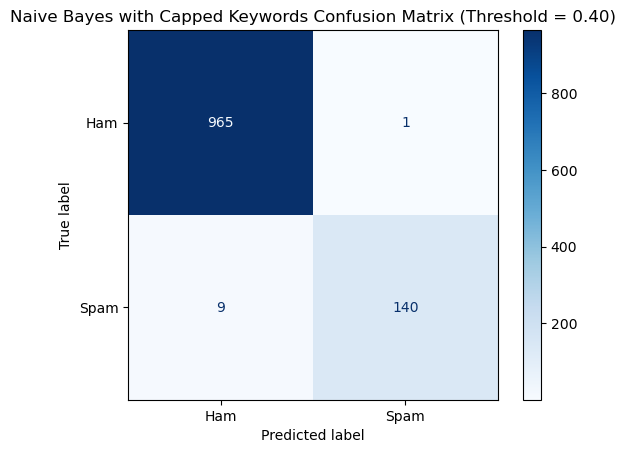

False Positives with Capped Keywords (Threshold 0.40):
1: MY NO. IN LUTON 0125698789 RING ME IF UR AROUND! H*
False Negatives with Capped Keywords (Threshold 0.40):
1: Your next amazing xxx PICSFREE1 video will be sent to you enjoy! If one vid is not enough for 2day text back the keyword PICSFREE1 to get the next video.
2: Babe: U want me dont u baby! Im nasty and have a thing 4 filthyguys. Fancy a rude time with a sexy bitch. How about we go slo n hard! Txt XXX SLO(4msgs)
3: Hello darling how are you today? I would love to have a chat, why dont you tell me what you look like and what you are in to sexy?
4: Do you realize that in about 40 years, we'll have thousands of old ladies running around with tattoos?
5: Will u meet ur dream partner soon? Is ur career off 2 a flyng start? 2 find out free, txt HORO followed by ur star sign, e. g. HORO ARIES
6: Talk sexy!! Make new friends or fall in love in the worlds most discreet text dating service. Just text VIP to 83110 and see who you could

In [92]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import re

# Load and preprocess data
data = pd.read_csv('./data/SMSSpamCollection', sep='\t', names=['label', 'text'])
data['label'] = data['label'].map({'ham': 0, 'spam': 1})

# Vectorize the text (unigrams only)
vectorizer = TfidfVectorizer(lowercase=True, stop_words='english')
X = vectorizer.fit_transform(data['text'])
y = data['label']

# Add custom features (phone, URL, price, short code, capped keywords, explicit)
def extract_features(text):
    phone = int(bool(re.search(r'\b\d{3}\d{6,}\b', text)))
    url = int(bool(re.search(r'http[s]?://\S+', text)))
    price = int(bool(re.search(r'£\d+|\d+p/min|\d+p/day', text)))
    short_code = int(bool(re.search(r'TXT to \d+', text)))
    keywords = min(1, len(re.findall(r'\b(free|win|txt|call)\b', text, re.I)))  # Cap at 1
    explicit = int(bool(re.search(r'xxx|sexy|nasty|cock', text, re.I)))
    return [phone, url, price, short_code, keywords, explicit]

features = np.array([extract_features(t) for t in data['text']])
X_custom = np.hstack((X.toarray(), features))  # Combine TF-IDF and custom features

# Split data with tracked indices
train_indices, test_indices = train_test_split(np.arange(len(data)), test_size=0.2, random_state=42)
X_train_custom, X_test_custom = X_custom[train_indices], X_custom[test_indices]
y_train, y_test = y[train_indices], y[test_indices]

# Train the model
model = MultinomialNB()
model.fit(X_train_custom, y_train)

# Predict with 0.40 threshold
y_prob = model.predict_proba(X_test_custom)[:, 1]
y_pred = (y_prob > 0.40).astype(int)

# Evaluate accuracy
accuracy = model.score(X_test_custom, y_test)
print(f"Accuracy (Threshold 0.40): {accuracy}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Ham', 'Spam'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Naive Bayes with Capped Keywords Confusion Matrix (Threshold = 0.40)')
plt.show()

# Extract false positives
fp_indices = np.where((y_test == 0) & (y_pred == 1))[0]
fp_original_indices = test_indices[fp_indices]
fp_texts = data.iloc[fp_original_indices]['text'].values
print("False Positives with Capped Keywords (Threshold 0.40):")
for i, text in enumerate(fp_texts):
    print(f"{i+1}: {text}")

# Extract false negatives
fn_indices = np.where((y_test == 1) & (y_pred == 0))[0]
fn_original_indices = test_indices[fn_indices]
fn_texts = data.iloc[fn_original_indices]['text'].values
print("False Negatives with Capped Keywords (Threshold 0.40):")
for i, text in enumerate(fn_texts):
    print(f"{i+1}: {text}")

Accuracy (Threshold 0.39): 0.9901345291479821


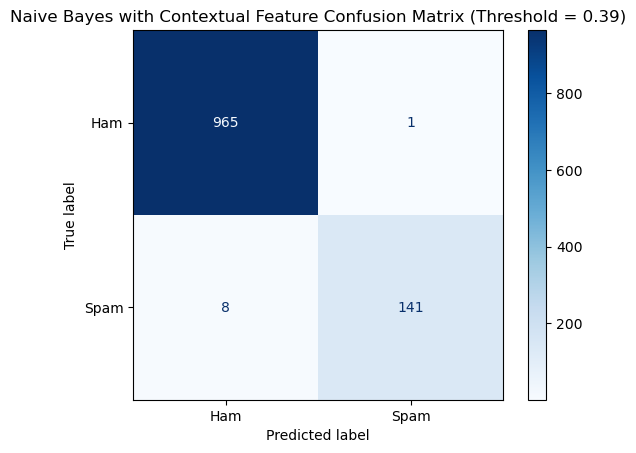

False Positives with Contextual Feature (Threshold 0.39):
1: MY NO. IN LUTON 0125698789 RING ME IF UR AROUND! H*
False Negatives with Contextual Feature (Threshold 0.39):
1: Your next amazing xxx PICSFREE1 video will be sent to you enjoy! If one vid is not enough for 2day text back the keyword PICSFREE1 to get the next video.
2: Babe: U want me dont u baby! Im nasty and have a thing 4 filthyguys. Fancy a rude time with a sexy bitch. How about we go slo n hard! Txt XXX SLO(4msgs)
3: Hello darling how are you today? I would love to have a chat, why dont you tell me what you look like and what you are in to sexy?
4: Do you realize that in about 40 years, we'll have thousands of old ladies running around with tattoos?
5: Will u meet ur dream partner soon? Is ur career off 2 a flyng start? 2 find out free, txt HORO followed by ur star sign, e. g. HORO ARIES
6: Talk sexy!! Make new friends or fall in love in the worlds most discreet text dating service. Just text VIP to 83110 and see who you

In [93]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import re

# Load and preprocess data
data = pd.read_csv('./data/SMSSpamCollection', sep='\t', names=['label', 'text'])
data['label'] = data['label'].map({'ham': 0, 'spam': 1})

# Vectorize the text (unigrams only)
vectorizer = TfidfVectorizer(lowercase=True, stop_words='english')
X = vectorizer.fit_transform(data['text'])
y = data['label']

# Add custom features (phone, URL, price, short code, capped keywords, explicit, contextual)
def extract_features(text):
    phone = int(bool(re.search(r'\b\d{3}\d{6,}\b', text)))
    url = int(bool(re.search(r'http[s]?://\S+', text)))
    price = int(bool(re.search(r'£\d+|\d+p/min|\d+p/day', text)))
    short_code = int(bool(re.search(r'TXT to \d+', text)))
    keywords = min(1, len(re.findall(r'\b(free|win|txt|call)\b', text, re.I)))
    explicit = int(bool(re.search(r'xxx|sexy|nasty|cock', text, re.I)))
    contextual = int(bool(re.search(r'join|meet|service', text, re.I)))
    return [phone, url, price, short_code, keywords, explicit, contextual]

features = np.array([extract_features(t) for t in data['text']])
X_custom = np.hstack((X.toarray(), features))  # Combine TF-IDF and custom features

# Split data with tracked indices
train_indices, test_indices = train_test_split(np.arange(len(data)), test_size=0.2, random_state=42)
X_train_custom, X_test_custom = X_custom[train_indices], X_custom[test_indices]
y_train, y_test = y[train_indices], y[test_indices]

# Train the model
model = MultinomialNB()
model.fit(X_train_custom, y_train)

# Predict with 0.39 threshold
y_prob = model.predict_proba(X_test_custom)[:, 1]
y_pred = (y_prob > 0.39).astype(int)

# Evaluate accuracy
accuracy = model.score(X_test_custom, y_test)
print(f"Accuracy (Threshold 0.39): {accuracy}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Ham', 'Spam'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Naive Bayes with Contextual Feature Confusion Matrix (Threshold = 0.39)')
plt.show()

# Extract false positives
fp_indices = np.where((y_test == 0) & (y_pred == 1))[0]
fp_original_indices = test_indices[fp_indices]
fp_texts = data.iloc[fp_original_indices]['text'].values
print("False Positives with Contextual Feature (Threshold 0.39):")
for i, text in enumerate(fp_texts):
    print(f"{i+1}: {text}")

# Extract false negatives
fn_indices = np.where((y_test == 1) & (y_pred == 0))[0]
fn_original_indices = test_indices[fn_indices]
fn_texts = data.iloc[fn_original_indices]['text'].values
print("False Negatives with Contextual Feature (Threshold 0.39):")
for i, text in enumerate(fn_texts):
    print(f"{i+1}: {text}")

# Random Forest

Random Forest Accuracy: 0.97847533632287


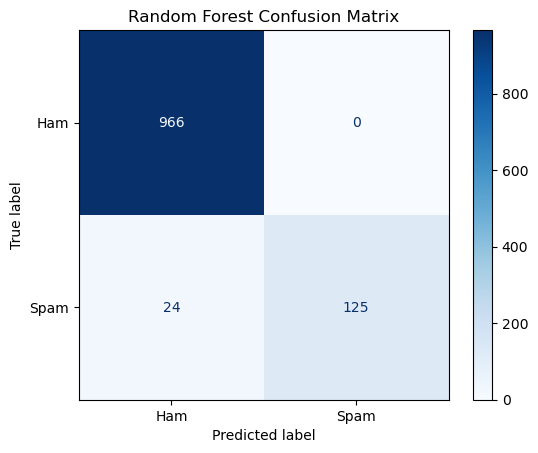

False Negatives with Random Forest:
1: Reminder: You have not downloaded the content you have already paid for. Goto http://doit. mymoby. tv/ to collect your content.
2: Oh my god! I've found your number again! I'm so glad, text me back xafter this msgs cst std ntwk chg £1.50
3: Your next amazing xxx PICSFREE1 video will be sent to you enjoy! If one vid is not enough for 2day text back the keyword PICSFREE1 to get the next video.
4: Rock yr chik. Get 100's of filthy films &XXX pics on yr phone now. rply FILTH to 69669. Saristar Ltd, E14 9YT 08701752560. 450p per 5 days. Stop2 cancel
5: Babe: U want me dont u baby! Im nasty and have a thing 4 filthyguys. Fancy a rude time with a sexy bitch. How about we go slo n hard! Txt XXX SLO(4msgs)
6: I want some cock! My hubby's away, I need a real man 2 satisfy me. Txt WIFE to 89938 for no strings action. (Txt STOP 2 end, txt rec £1.50ea. OTBox 731 LA1 7WS. )
7: Hello darling how are you today? I would love to have a chat, why dont you tell me wh

In [94]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load and preprocess data
data = pd.read_csv('./data/SMSSpamCollection', sep='\t', names=['label', 'text'])
data['label'] = data['label'].map({'ham': 0, 'spam': 1})
vectorizer = TfidfVectorizer(lowercase=True, stop_words='english')
X = vectorizer.fit_transform(data['text'])
y = data['label']

# Split data with tracked indices
train_indices, test_indices = train_test_split(np.arange(len(data)), test_size=0.2, random_state=42)
X_train, X_test = X[train_indices], X[test_indices]
y_train, y_test = y[train_indices], y[test_indices]

# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_rf = rf_model.predict(X_test)
accuracy_rf = rf_model.score(X_test, y_test)
print(f"Random Forest Accuracy: {accuracy_rf}")

# Confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf, labels=[0, 1])
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=['Ham', 'Spam'])
disp_rf.plot(cmap=plt.cm.Blues)
plt.title('Random Forest Confusion Matrix')
plt.show()

# Extract false negatives (if needed)
fn_indices_rf = np.where((y_test == 1) & (y_pred_rf == 0))[0]
fn_original_indices_rf = test_indices[fn_indices_rf]
fn_texts_rf = data.iloc[fn_original_indices_rf]['text'].values
print("False Negatives with Random Forest:")
for i, text in enumerate(fn_texts_rf):
    print(f"{i+1}: {text}")

Best Parameters: {'n_estimators': 100, 'min_samples_split': 6, 'max_depth': 20}
Best Cross-Validation Accuracy: 0.9396448408112832
Random Forest Accuracy: 0.9488789237668162


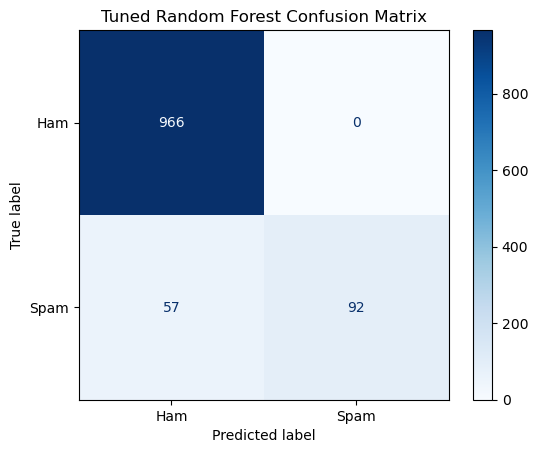

False Negatives with Tuned Random Forest:
1: Reminder: You have not downloaded the content you have already paid for. Goto http://doit. mymoby. tv/ to collect your content.
2: Guess what! Somebody you know secretly fancies you! Wanna find out who it is? Give us a call on 09065394973 from Landline DATEBox1282EssexCM61XN 150p/min 18
3: Oh my god! I've found your number again! I'm so glad, text me back xafter this msgs cst std ntwk chg £1.50
4: Your next amazing xxx PICSFREE1 video will be sent to you enjoy! If one vid is not enough for 2day text back the keyword PICSFREE1 to get the next video.
5: Rock yr chik. Get 100's of filthy films &XXX pics on yr phone now. rply FILTH to 69669. Saristar Ltd, E14 9YT 08701752560. 450p per 5 days. Stop2 cancel
6: Babe: U want me dont u baby! Im nasty and have a thing 4 filthyguys. Fancy a rude time with a sexy bitch. How about we go slo n hard! Txt XXX SLO(4msgs)
7: I want some cock! My hubby's away, I need a real man 2 satisfy me. Txt WIFE to 89938 

In [95]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load and preprocess data
data = pd.read_csv('./data/SMSSpamCollection', sep='\t', names=['label', 'text'])
data['label'] = data['label'].map({'ham': 0, 'spam': 1})
vectorizer = TfidfVectorizer(lowercase=True, stop_words='english')
X = vectorizer.fit_transform(data['text'])
y = data['label']

# Split data with tracked indices
train_indices, test_indices = train_test_split(np.arange(len(data)), test_size=0.2, random_state=42)
X_train, X_test = X[train_indices], X[test_indices]
y_train, y_test = y[train_indices], y[test_indices]

# Define parameter distribution for tuning
param_dist = {
    'n_estimators': [100, 150, 200],
    'max_depth': [10, 15, 20],
    'min_samples_split': [2, 4, 6]
}

# Initialize and tune Random Forest
rf = RandomForestClassifier(random_state=42)
random_search = RandomizedSearchCV(rf, param_distributions=param_dist, n_iter=10, cv=3, scoring='accuracy', n_jobs=-1, random_state=42)
random_search.fit(X_train, y_train)

# Best model
best_rf = random_search.best_estimator_
print(f"Best Parameters: {random_search.best_params_}")
print(f"Best Cross-Validation Accuracy: {random_search.best_score_}")

# Predict and evaluate
y_pred_rf = best_rf.predict(X_test)
accuracy_rf = best_rf.score(X_test, y_test)
print(f"Random Forest Accuracy: {accuracy_rf}")

# Confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf, labels=[0, 1])
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=['Ham', 'Spam'])
disp_rf.plot(cmap=plt.cm.Blues)
plt.title('Tuned Random Forest Confusion Matrix')
plt.show()

# Extract false negatives
fn_indices_rf = np.where((y_test == 1) & (y_pred_rf == 0))[0]
fn_original_indices_rf = test_indices[fn_indices_rf]
fn_texts_rf = data.iloc[fn_original_indices_rf]['text'].values
print("False Negatives with Tuned Random Forest:")
for i, text in enumerate(fn_texts_rf):
    print(f"{i+1}: {text}")

# Using a more modern data set to test the model

We created a set of 593 more modern text messages using Claude AI to test the model.

In [96]:
modern_spam_df = pd.read_csv('./data/spam_sms_dataset.csv')
modern_spam_df['label'].value_counts()

label
spam    297
ham     296
Name: count, dtype: int64

In [97]:
modern_spam_df['label'] = modern_spam_df['label'].replace(['ham', 'spam'], [0, 1])
modern_spam_df['lower_message'] = modern_spam_df['message'].str.lower()
modern_spam_df['message_wo_punct'] = modern_spam_df["lower_message"].apply(lambda text: remove_punctuation(text))
modern_spam_df['message_no_stopwords'] = modern_spam_df['message_wo_punct'].apply(lambda text: remove_stopwords(text))
modern_spam_df['message_lemmatized'] = modern_spam_df['message_no_stopwords'].apply(lambda text: lemmatize_words(text))
modern_spam_df

/var/folders/4s/pf1zdv_x4_qcflpq4m943q0m0000gn/T/ipykernel_77414/15539428.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  modern_spam_df['label'] = modern_spam_df['label'].replace(['ham', 'spam'], [0, 1])


,label,message,lower_message,message_wo_punct,message_no_stopwords,message_lemmatized
0,0,"Hey, are we still meeting for coffee tomorrow ...","hey, are we still meeting for coffee tomorrow ...",hey are we still meeting for coffee tomorrow at 3,hey still meeting coffee tomorrow 3,hey still meet coffee tomorrow 3
1,1,CONGRATULATIONS! You've WON a FREE iPhone 14! ...,congratulations! you've won a free iphone 14! ...,congratulations youve won a free iphone 14 cli...,congratulations youve free iphone 14 click cla...,congratulation youve free iphone 14 click clai...
2,0,Don't forget to pick up milk on your way home ...,don't forget to pick up milk on your way home ...,dont forget to pick up milk on your way home p...,dont forget pick milk way home please,dont forget pick milk way home please
3,1,URGENT: Your bank account has been suspended. ...,urgent: your bank account has been suspended. ...,urgent your bank account has been suspended ca...,urgent bank account suspended call immediately...,urgent bank account suspend call immediately 1...
4,0,The meeting has been moved to 2pm instead of 3...,the meeting has been moved to 2pm instead of 3...,the meeting has been moved to 2pm instead of 3...,meeting moved 2pm instead 3pm see,meet move 2pm instead 3pm see
...,...,...,...,...,...,...
588,1,FINAL WARNING: Your internet service will be d...,final warning: your internet service will be d...,final warning your internet service will be di...,final warning internet service disconnected to...,final warning internet service disconnect tomo...
589,0,Can you pick up the kids from daycare today? I...,can you pick up the kids from daycare today? i...,can you pick up the kids from daycare today im...,pick kids daycare today im stuck meeting,pick kid daycare today im stick meeting
590,1,EXCLUSIVE OFFER: Get 85% OFF designer handbags...,exclusive offer: get 85% off designer handbags...,exclusive offer get 85 off designer handbags l...,exclusive offer get 85 designer handbags limit...,exclusive offer get 85 designer handbag limit ...
591,0,Don't forget to call mom for her birthday tomo...,don't forget to call mom for her birthday tomo...,dont forget to call mom for her birthday tomorrow,dont forget call mom birthday tomorrow,dont forget call mom birthday tomorrow


In [98]:
modern_spam_test = tfidf_vectorizer.transform(modern_spam_df['message_lemmatized'])

In [99]:
modern_pred = lr_classifier.predict(modern_spam_test)

print(accuracy_score(modern_spam_df['label'], modern_pred))

0.8870151770657673


Using the existing model that we trained previously, we can see that it does not perform as well on data with more modern SMS messages.